# Project 2

Alice Ding, Shoshana Farber, Christian Uriostegui

The goal of this project is to:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

The dataset we are using is from the Bureau of Transporation Statistics, specifically from the Airline Origin and Destination (DB1B) [database](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FHK&QO_fu146_anzr=b4vtv0%20n0q%20Qr56v0n6v10%20f748rB&V0s1_b0yB=D). The dataset used can be found in the [GitHub folder Week 4 - Part 1](https://github.com/addsding/cuny-data620/tree/main/week4_part1) assignment.  Because the dataset exceeds a million rows, we will be looking a smaller subset of data for practical purposes. The full original dataset can be found [here](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FHK&QO_fu146_anzr=b4vtv0+n0q+Qr56v0n6v10+f748rB). 

The dataset contains information on the origin and destination markets provided in the Origin and Destination Survey (DB1B). This is a 10% sample of airline ticket purchases from carriers. In addition, you can find information on the number of passengers, as well as origin and destination airlines. This information is recorded each quarter and has been reported since 1993. 

For our analysis, we will be looking at data from 2022 in the first quarter. We are interested in examining popular destination places by airline companies in the United States.

***

### Loading the Data

In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

In [2]:
survey = pd.read_csv('https://raw.githubusercontent.com/addsding/cuny-data620/main/week4_part1/T_DB1B_MARKET_1.csv')

In [3]:
survey.head()

,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_STATE_ABR,DEST_STATE_NM,REPORTING_CARRIER,PASSENGERS
0,2022149,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
1,2022150,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
2,2022151,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
3,2022151,13204,1320402,31454,MCO,FL,Florida,10868,1086803,30868,CAE,SC,South Carolina,3M,1
4,2022152,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1


Our dataframe titled **survey** contains the following columns:
- `ITIN_ID`- This contains the unique itenary ID for each flight
- `ORIGIN_AIRPORT_ID` - Origin airport id
- `ORIGIN_AIRPORT_SEQ_ID` - Origin airport sequence id
- `ORIGIN_CITY_MARKET_ID` - Origin city market
- `ORIGIN` - Origin airport code
- `ORIGIN_STATE_ABR` - Origin state abbreviation
- `ORIGIN_STATE_NM`- Origin state full name
- `DEST_AIRPORT_ID` - Destination airport id
- `DEST_AIRPORT_SEQ_ID` - Destination airport sequence id
- `DEST_CITY_MARKET_ID` -Destination city market id
- `DEST` - Destination airport code
- `DEST_STATE_ABR` - Destination state abbreviation
- `DEST_STATE_NM` - Destination state name
- `REPORTING_CARRIER` - Reporting carrier code (3M = Silver Airways, 9E = Endeavor Air Inc., AA = American Airlines Inc.)
- `PASSENGERS` - Number of passengers traveling per itinerary

For our analysis, we will be examining the columns `REPORTING_CARRIER` and `DEST_STATE_ABR`.
***

### Exploratory Analysis
**What are the carriers and destination states? in the dataset**

In [54]:
print("There are",len(survey['REPORTING_CARRIER'].unique()), "airline carriers and they are", survey['REPORTING_CARRIER'].unique(),"\n")
print("There are",len(survey['DEST_STATE_ABR'].unique()), "destination states and they are", survey['DEST_STATE_ABR'].unique())

There are 3 airline carriers and they are ['3M' '9E' 'AA'] 

There are 52 destination states and they are ['FL' 'SC' 'NJ' 'NY' 'GA' 'CT' 'MA' 'OH' 'NC' 'VA' 'CO' 'MT' 'MI' 'TX'
 'ID' 'OK' 'AZ' 'AR' 'MN' 'IL' 'IN' 'MS' 'WY' 'AL' 'ME' 'CA' 'NE' 'PA'
 'MO' 'OR' 'PR' 'UT' 'KY' 'WA' 'LA' 'RI' 'TN' 'SD' 'HI' 'AK' 'VI' 'NM'
 'NV' 'WI' 'ND' 'WV' 'IA' 'KS' 'MD' 'VT' 'NH' 'TT']


Note that we know about the carriers and destination places in the data, we can look at the frequency for each column.
***
**What airlines carriers has the most trips?**

In [22]:
survey.groupby('REPORTING_CARRIER').count().iloc[:, 0].sort_values(ascending=False)

REPORTING_CARRIER
9E    140539
AA    133601
3M      3324
Name: ITIN_ID, dtype: int64

Between the three carriers, Endeavor Air Inc (9E) has the most trips in the dataset with **140539**, followed by American Airlines with **133601**, and Silver Airways with **3324**.
***
**What are the most visited destinations?**

In [56]:
survey.groupby('DEST_STATE_ABR').count().iloc[:,0].sort_values(ascending=False).head()

DEST_STATE_ABR
FL    31049
NY    26804
TX    22762
NC    18130
MA    16062
Name: ITIN_ID, dtype: int64

The most frequent destination is Florida with **31049**, and next is New York with **26804**.
***

### Creating the Network

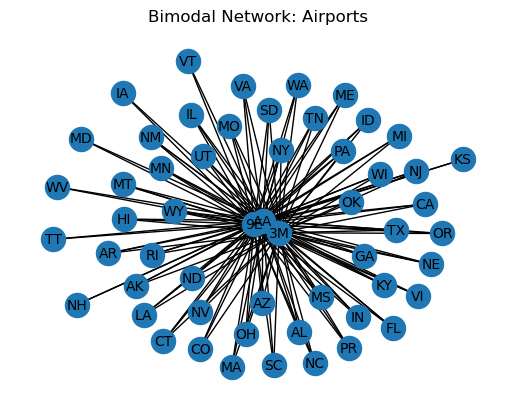

In [55]:
# Create an empty graph
G = nx.Graph()

# Iterate over the data rows
for _, row in survey.iterrows():
    airline = row['REPORTING_CARRIER']
    dest = row['DEST_STATE_ABR']

    # Add the nodes and edges to the graph
    G.add_node(airline, bipartite=0)  # Airline carrier nodes
    G.add_node(dest, bipartite=1)  # Destination state nodes
    G.add_edge(airline, dest)  # Edge between carrier and destination

# 1. Network visualization
pos = nx.bipartite_layout(G, [n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
nx.draw_networkx(G,node_size=300, font_size=10)
plt.title("Bimodal Network: Airports")
plt.axis("off")
plt.show()